## DIGIT Force Calibration

### Overview

This notebook compares measurements across different objects, motions, and FSR placements, establishes thresholds for three discrete force levels, and calibrates voltage readings to Newtons. Together, these steps provide a reliable baseline for using an FSR mounted on the rear of a DIGIT tactile sensor.  

When handling the DIGIT sensor, the forefinger rests on the rear FSR to control the applied pressure, while the thumb and middle finger hold the sides solely for stability. All cables are positioned so they remain clear of the workspace and do not interfere with data collection.

All readings are obtained in a standard home office with an average room temperateure of ~20.5°C.

### Imports and Useful Functions

In [420]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import confusion_matrix

In [421]:
def plot_voltage_over_time(df, column_name):
    """
    Plots the voltage over time for different values in the specified column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to analyse.
    """
    # Extract possible values for the specified column
    vals = df[column_name].unique()

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot the voltage for each value
    for val in vals:
        data = df[df[column_name] == val]
        sns.lineplot(data=data, x='time_s', y='voltage', label=val)
    
    # Labels and title
    plt.title('FSR Voltage Over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

In [422]:
def plot_voltage_by_force(df, type='box'):
    """
    Creates a boxplot or violin plot of voltage grouped by force levels.

    Args:
        df (pd.DataFrame): The input DataFrame.
        type (str): Type of plot to create ('box' or 'violin').
    """
    # Create boxplot
    plt.figure(figsize=(10, 6))
    
    if type == 'box':
        ax = sns.boxplot(
            data=df,
            x='force',
            y='voltage',
        )
    elif type == 'violin':
        # Violin plot
        ax = sns.violinplot(
            data=df,
            x='force',
            y='voltage',
            inner='quartile',  # Show median + quartiles inside the violin
            cut=0,  # Do not extend beyond min/max of data
        )
    
    # Titles and labels
    ax.set_title('Voltage Distribution per Force Level', fontsize=14, pad=15)
    ax.set_xlabel('Force Level', fontsize=12)
    ax.set_ylabel('Voltage (V)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [423]:
def threshold_cm(actual, classified, labels):
    # Confusion matrix
    cm = confusion_matrix(actual, classified, labels=labels)

    # Plot
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )

    plt.title("Confusion Matrix for Force-Level Thresholds")
    plt.xlabel("Classified Force Level")
    plt.ylabel("Actual Force Level")
    plt.tight_layout()
    plt.show()

In [424]:
def remove_iqr_outliers(df, col, k=1.5):
    """
    Remove IQR outliers from a Pandas DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame.
        col (str): Name of the column to check for outliers.
        k (float, optional): IQR multiplier used to define outlier thresholds.
            Defaults to 1.5.

    Returns:
        pandas.DataFrame: DataFrame with outliers removed based on the IQR rule.
    """
    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR

    # Keep only non-outliers
    return df[(df[col] >= lower) & (df[col] <= upper)]

### Object Comparison

I performed a ‘long press’ of the DIGIT sensor on five different objects and recorded the FSR data (raw value and converted voltage) for two seconds (at ~20hz). A long press involves beginning with light contact and then steadily increasing the applied force until reaching a full press. For all of these trials, the sensor was held facing downwards.

In [425]:
# Load the CSV data
df_press = pd.read_csv('data/press_data.csv')
df_press.head()

,object,time_s,raw,voltage
0,beans,0.001,320,0.0161
1,beans,0.052,944,0.0475
2,beans,0.103,304,0.0153
3,beans,0.153,896,0.0451
4,beans,0.204,320,0.0161


Below, I plot the FSR voltage over time for each object to assess whether any visible differences emerge across objects.

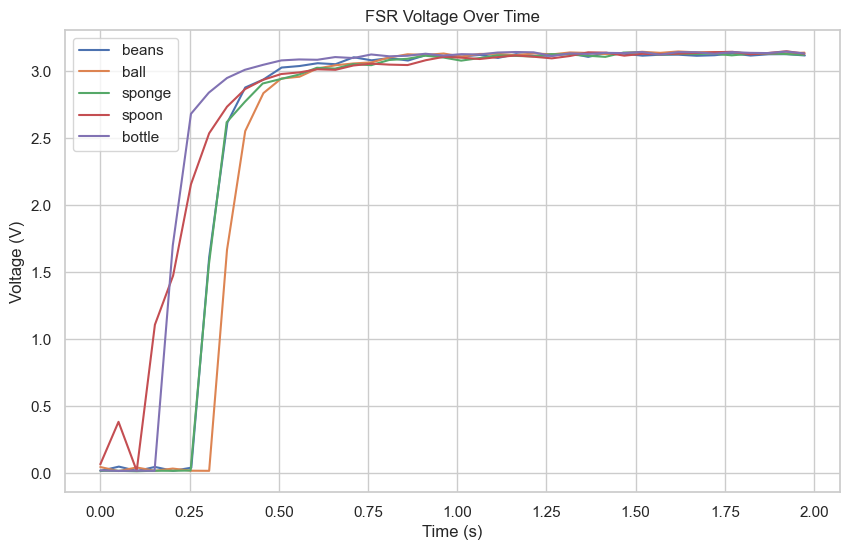

In [426]:
# Plot the curves for each object in the press data
plot_voltage_over_time(df_press, 'object')

The traces are broadly very similar across objects, with all reaching nearly the same steady-state voltage once fully pressed. Minor differences in the ramp-up phase, as well as the small spike at the start of one trial, are expected and likely due to normal human variation in the pressing motion. Overall, the steady-state output is consistent and largely object-independent.

### FSR Position Comparison

I performed a ‘long press’ of the DIGIT sensor on a tennis ball (chosen for its consistent texture and geometry) in several orientations to test whether the FSR’s angle affected the output. Specifically, I pressed downwards on the top of the ball, sideways on the right side, and upwards on the bottom, while holding the ball in my other hand to prevent movement.

In [ ]:
# Load the CSV data
df_press_pos = pd.read_csv('data/test.csv')
df_press_pos.head()

,position,time_s,raw,voltage
0,top,0.000,320,0.0161
1,top,0.051,2464,0.1241
2,top,0.103,4177,0.2103
3,top,0.154,17636,0.8881
4,top,0.205,13747,0.6922


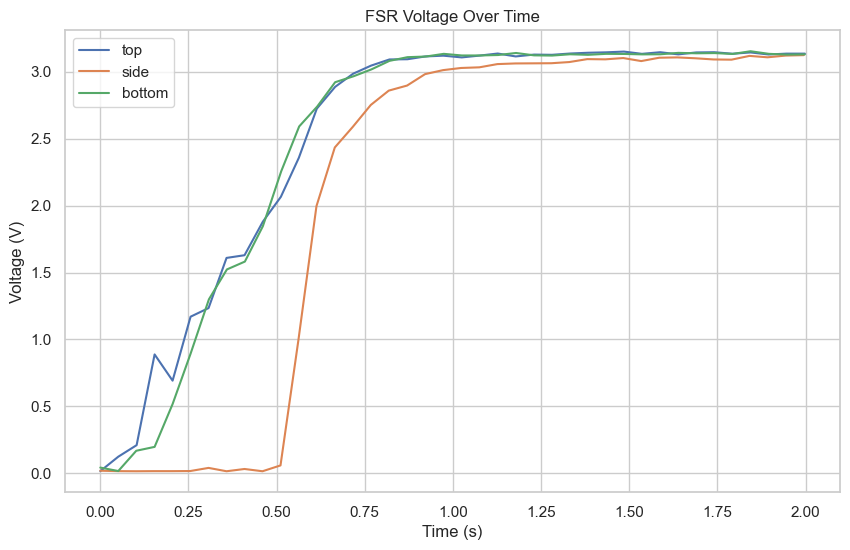

In [447]:
# Plot the curves for each position in the press position data
plot_voltage_over_time(df_press_pos, 'position')

Analysis here...

### Force Level Thresholds

I collected FSR readings by performing sliding and rotational motions across five different objects under three manually applied force conditions. Level 1 involved making contact with the object without exerting pressure, Level 2 introduced light pressure resulting in slight deformation, and Level 3 applied firm pressure, producing marked deformation while remaining within safe limits for both the sensor and the object.  

The aim was to record both raw and converted voltage readings in order to gauge suitable thresholds for the three discrete force levels.

In [429]:
# Load the CSV data
df_motion = pd.read_csv('data/motion_data.csv')
df_motion.head()

,object,motion,force,raw,voltage
0,beans,slide,1,336,0.0169
1,beans,slide,1,464,0.0234
2,beans,slide,1,320,0.0161
3,beans,slide,1,256,0.0129
4,beans,slide,1,336,0.0169


In [430]:
# Initial stats
force_stats = df_motion.groupby('force')['voltage'].describe()
force_stats

,count,mean,std,min,25%,50%,75%,max
force,,,,,,,,
1,500.0,0.022411,0.010863,0.0073,0.0161,0.0169,0.0290,0.0540
2,500.0,2.599554,0.552760,0.0161,2.6104,2.7859,2.9064,3.0107
3,500.0,3.054284,0.053176,2.5828,3.0357,3.0574,3.0792,3.1373


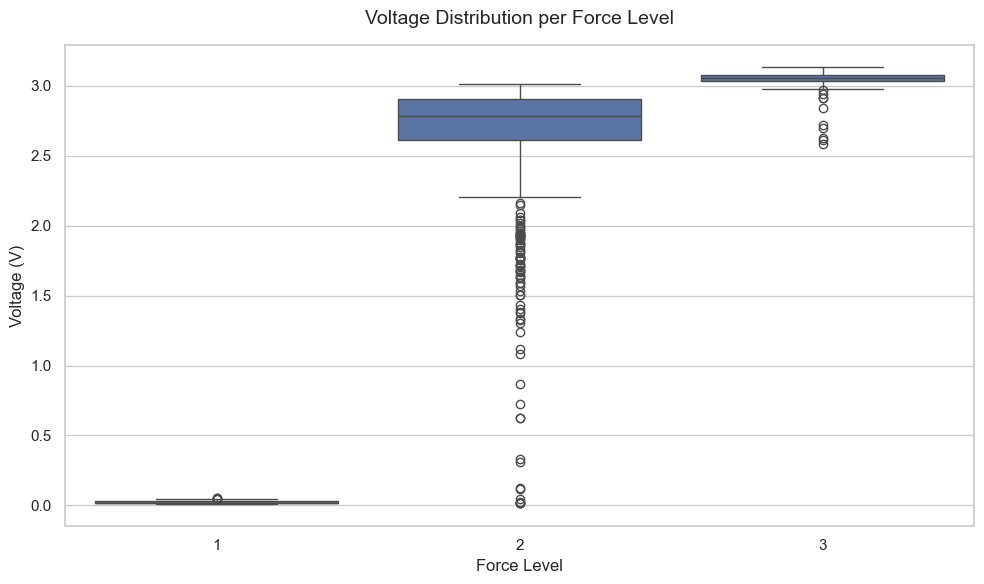

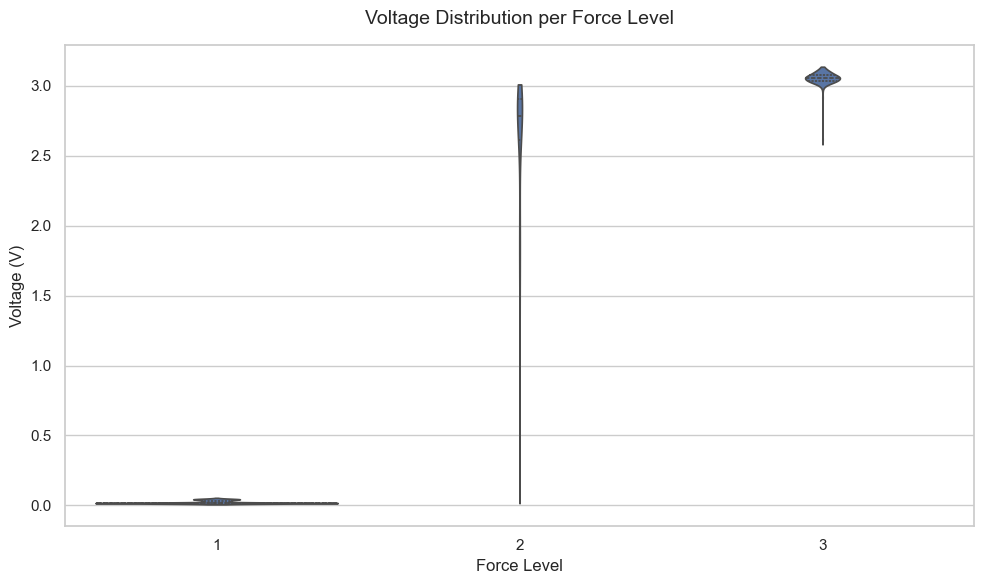

In [431]:
# Show boxplot and violin plots for the data
plot_voltage_by_force(df_motion, type='box')
plot_voltage_by_force(df_motion, type='violin')

In [432]:
# Remove outliers from motion data
df_motion_clean = (
    df_motion
    .groupby('force', group_keys=False)
    .apply(remove_iqr_outliers, col='voltage', k=1.5)
)
 
df_motion_clean['force'].value_counts()

/var/folders/wp/c8l2zvtj0s74nmvn23mcmxnw0000gn/T/ipykernel_84300/2830996492.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_iqr_outliers, col='voltage', k=1.5)


force
1    495
3    490
2    425
Name: count, dtype: int64

In [433]:
# Cleaned stats
force_stats_clean = df_motion_clean.groupby('force')['voltage'].describe()
force_stats_clean

,count,mean,std,min,25%,50%,75%,max
force,,,,,,,,
1,495.0,0.022124,0.010533,0.0073,0.0161,0.0169,0.0270,0.0483
2,425.0,2.799248,0.152900,2.2089,2.7166,2.8391,2.9140,3.0107
3,490.0,3.059829,0.030580,2.9785,3.0367,3.0582,3.0812,3.1373


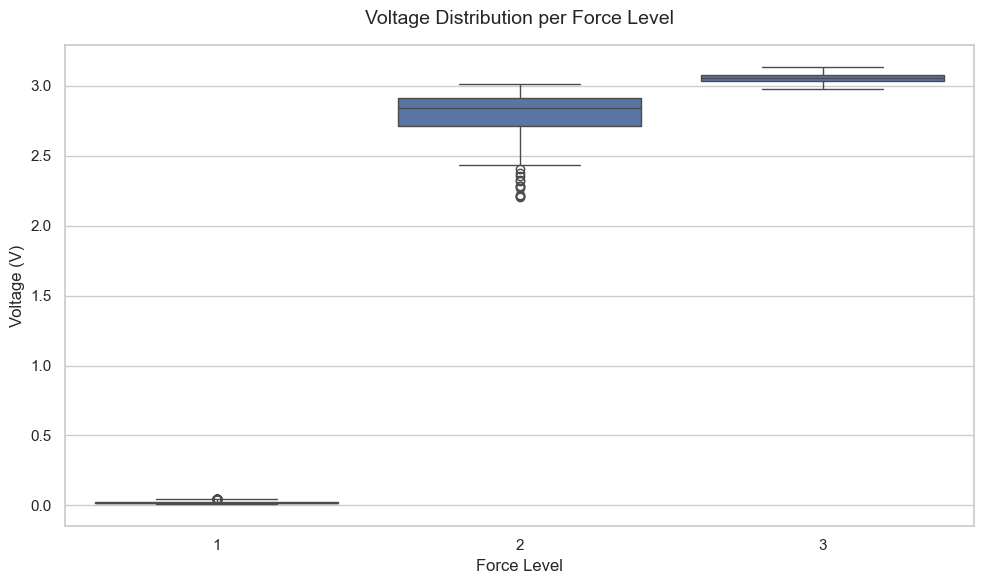

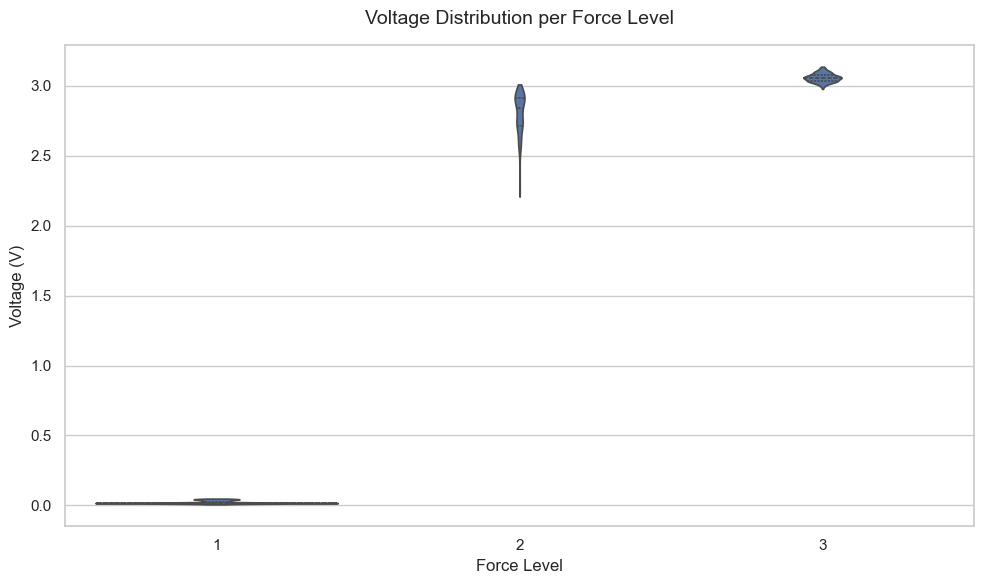

In [434]:
# Show boxplot and violin plots for the cleaned data
plot_voltage_by_force(df_motion_clean, type='box')
plot_voltage_by_force(df_motion_clean, type='violin')

To support the visual and statistical analysis above, the following table summarises the final force-level voltage thresholds that will be used for classification.

| Force Level | Voltage Range (V) |
| ----------- | ----------------- |
| **Level 1** | 0 – 0.99          |
| **Level 2** | 1 – 2.99          |
| **Level 3** | 3+                |


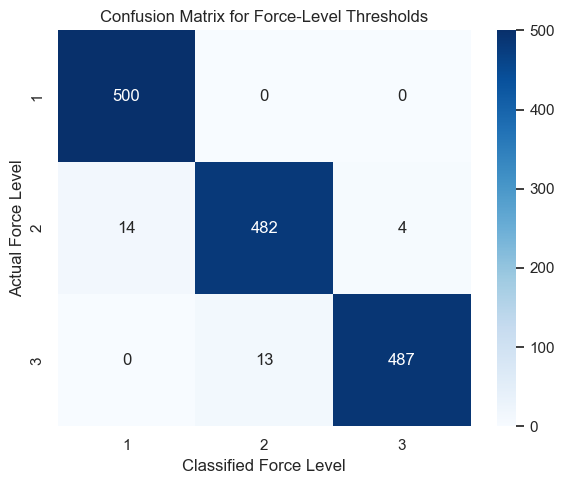

In [435]:
# Force-level thresholds
def classify_thresholds(v):
    if v < 0.99:
        return 1
    elif v < 2.99:
        return 2
    else:
        return 3

# Classify based on thresholds
df_motion['classified'] = df_motion['voltage'].apply(classify_thresholds)

# Confusion matrix
threshold_cm(df_motion['force'], df_motion['classified'], labels=[1,2,3])

In [ ]:
# Overall accuracy
overall_acc = (df_motion['classified'] == df_motion['force']).sum() / len(df_motion)
print(f"Overall accuracy: {overall_acc:.2f}%")

# Per-class accuracy
per_class_acc = df_motion.groupby('force').apply(
    lambda g: (g['classified'] == g['force']).sum() / len(g)
)

print('\nAccuracy per force level:')
print(per_class_acc)

Overall accuracy: 0.98%

Accuracy per force level:
force
1    1.000
2    0.964
3    0.974
dtype: float64


/var/folders/wp/c8l2zvtj0s74nmvn23mcmxnw0000gn/T/ipykernel_84300/3229584455.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_acc = df_motion.groupby('force').apply(


### Voltage to Newtons Calibration

Notes:  
Remove outliers   
Average  
Convert to N  
Fit curve  
Run inference on new V and get for each threshold  

Cables not touching, placed in centre of scales